# RegNetY_008

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [2]:
#|export
from fastai.vision.all import *
from fastai.distributed import *
import timm

In [3]:
#|export
set_seed(42)

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 200)

In [5]:
#|export
dataroot_path = Path('/home/exsdatalab/data/surgvu24')

In [6]:
#|export
images_df=pd.read_csv(dataroot_path/'frames_info.csv')

In [7]:
len(images_df)

279175

In [8]:
# Step 1: Apply the label mapping (assuming this has already been done in the previous step)
label_mapping = {
    "Range of motion": "range_of_motion",
    "Rectal artery/vein": "rectal_artery_vein",
    "Retraction and collision avoidance": "retraction_collision_avoidance",
    "Skills application": "skills_application",
    "Suspensory ligaments": "suspensory_ligaments",
    "Suturing": "suturing",
    "Uterine horn": "uterine_horn",
    "Other/Unannotated": "other"
}

# Apply the mapping to the task_label column in images_df
images_df['task_label'] = images_df['task_label'].map(label_mapping)


In [9]:
# Print unique labels after modification
task_labels = images_df['task_label'].unique()
list(task_labels)

['other',
 'skills_application',
 'uterine_horn',
 'suspensory_ligaments',
 'rectal_artery_vein',
 'suturing',
 'retraction_collision_avoidance',
 'range_of_motion']

In [10]:
#|export
def splitter(df):
    train = df.index[~df['valid']].tolist()
    valid = df.index[df['valid']].tolist()
    return train, valid

In [11]:
#|export
def get_image(r): 
    return str(dataroot_path) + '/frames/' + r['filename'] + '.jpg'

In [12]:
#|export
def get_label(r): return r['task_label']

In [14]:
#|export
def get_dblock(item_tfms, batch_tfms):
    dblock = DataBlock(blocks=(ImageBlock, CategoryBlock(task_labels)),  # Ensure the data types are correct
                       get_x=get_image,
                       get_y=get_label,
                       splitter=splitter,
                       item_tfms=item_tfms,
                       batch_tfms=batch_tfms)
    return dblock

In [37]:
#|export
dblock = get_dblock(
    item_tfms=Resize((216,384), method=ResizeMethod.Squish),
    batch_tfms=[*aug_transforms(size=(216,384), min_scale=1), Normalize.from_stats(*imagenet_stats)]
)

dls = dblock.dataloaders(images_df, bs=64, seed=42)

In [38]:
dls.vocab

['other', 'range_of_motion', 'rectal_artery_vein', 'retraction_collision_avoidance', 'skills_application', 'suspensory_ligaments', 'suturing', 'uterine_horn']

In [43]:
learn = vision_learner(dls, 'regnety_008', 
                       metrics=[accuracy, error_rate,
                                Precision(average='macro'),
                                Recall(average='macro'),
                                F1Score(average='macro')
                                ])

model.safetensors:   0%|          | 0.00/25.2M [00:00<?, ?B/s]

In [44]:
learn.summary()

Sequential (Input shape: 64 x 3 x 216 x 384)
Layer (type)         Output Shape         Param #    Trainable 
                     64 x 32 x 108 x 192 
Conv2d                                    864        False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 108 x 192 
Conv2d                                    2048       False     
Identity                                                       
ReLU                                                           
____________________________________________________________________________
                     64 x 64 x 54 x 96   
Conv2d                                    9216       False     
Identity                                                       
ReLU                                                           
___________________________________

SuggestedLRs(valley=0.010964781977236271)

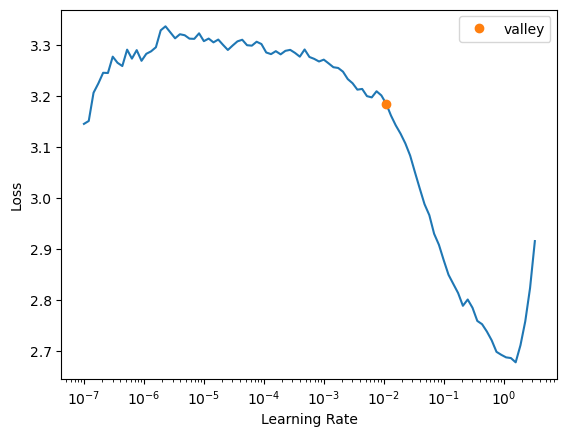

In [45]:
learn.lr_find()

In [46]:
learn.freeze()
learn.fit_one_cycle(10, 1e-3) 

epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,recall_score,f1_score,time
0,1.131166,0.881528,0.689680,0.310320,0.587204,0.537117,0.532277,11:16
1,0.597117,0.595293,0.791135,0.208865,0.767053,0.711559,0.715613,10:42
2,0.489832,0.546497,0.809150,0.190850,0.787037,0.760547,0.765429,10:29
3,0.443205,0.533838,0.808371,0.191629,0.780604,0.748560,0.754626,11:23
4,0.390595,0.556957,0.806695,0.193305,0.792381,0.744670,0.755770,10:24
5,0.362051,0.533001,0.813944,0.186056,0.794359,0.772816,0.767586,10:53
6,0.361375,0.551908,0.806944,0.193056,0.797598,0.724821,0.744775,11:14
7,0.341797,0.542372,0.812219,0.187781,0.800394,0.739788,0.758233,10:21
8,0.349031,0.551871,0.811705,0.188295,0.796641,0.734693,0.750700,10:49
9,0.319965,0.549220,0.809548,0.190452,0.802220,0.712587,0.738168,10:05


SuggestedLRs(valley=0.0006918309954926372)

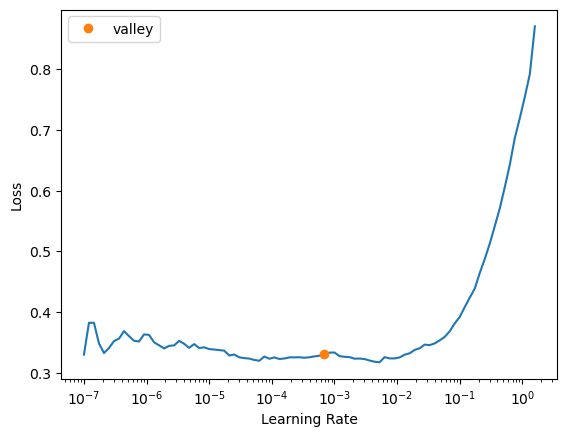

In [47]:
learn.unfreeze()
learn.lr_find()

In [48]:
learn.fit_one_cycle(20, slice(1e-3/400, 1e-3/4))     

epoch,train_loss,valid_loss,accuracy,error_rate,precision_score,recall_score,f1_score,time
0,0.340718,0.554020,0.809465,0.190535,0.797917,0.724100,0.744738,10:37
1,0.336193,0.551211,0.810427,0.189573,0.800006,0.723331,0.744823,11:28
2,0.337279,0.549822,0.811307,0.188693,0.800032,0.727415,0.748224,11:34
3,0.327196,0.553747,0.810361,0.189639,0.797557,0.726518,0.746426,07:56
4,0.330978,0.549587,0.811008,0.188992,0.799000,0.731206,0.751731,05:43
5,0.343415,0.548811,0.812518,0.187482,0.796152,0.734794,0.751801,05:37
6,0.321141,0.551442,0.810112,0.189888,0.800058,0.718017,0.742891,05:39
7,0.329852,0.554926,0.810909,0.189091,0.800065,0.732107,0.753444,05:44
8,0.337316,0.556508,0.809980,0.190020,0.797063,0.729257,0.748374,05:39
9,0.311322,0.556458,0.810577,0.189423,0.794457,0.730718,0.747748,05:39


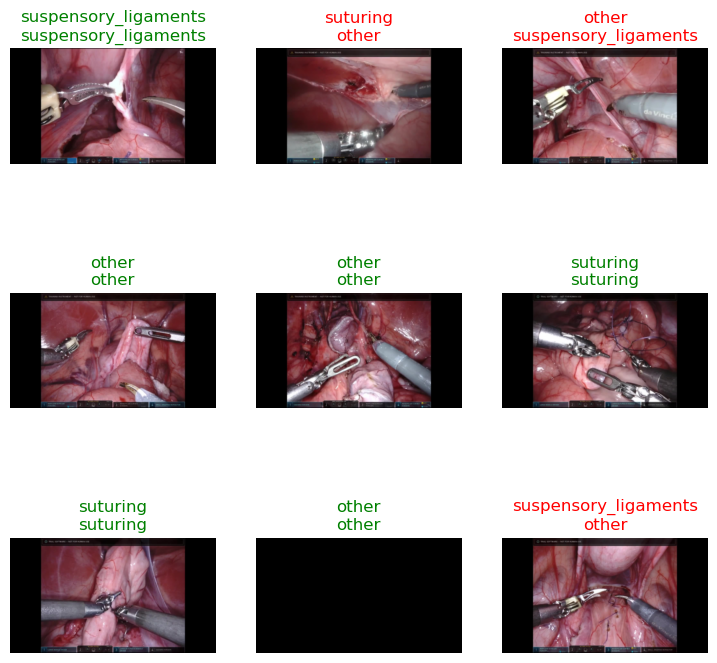

In [50]:
learn.show_results()

In [49]:
#|export
learn.path = Path('models/baseline')
learn.export("regnety_008.pkl")